# Setting up the environment

In [1]:
# @title Setup code (not important) - Run this cell by pressing "Shift + Enter"


import imageio

!pip install -qq gym==0.23.0


from typing import Tuple, Dict, Optional, Iterable, Callable

import numpy as np
import seaborn as sns
import matplotlib
from matplotlib import animation

from IPython.display import HTML

import gym
from gym import spaces
from gym.error import DependencyNotInstalled

import pygame
from pygame import gfxdraw


class Maze(gym.Env):

    def __init__(self, exploring_starts: bool = False,
                 shaped_rewards: bool = False, size: int = 5) -> None:
        super().__init__()
        self.exploring_starts = exploring_starts
        self.shaped_rewards = shaped_rewards
        self.state = (size - 1, size - 1)
        self.goal = (size - 1, size - 1)
        self.maze = self._create_maze(size=size)
        self.distances = self._compute_distances(self.goal, self.maze)
        self.action_space = spaces.Discrete(n=4)
        self.action_space.action_meanings = {0: 'UP', 1: 'RIGHT', 2: 'DOWN', 3: "LEFT"}
        self.observation_space = spaces.MultiDiscrete([size, size])

        self.screen = None
        self.agent_transform = None

    def step(self, action: int) -> Tuple[Tuple[int, int], float, bool, Dict]:
        reward = self.compute_reward(self.state, action)
        self.state = self._get_next_state(self.state, action)
        done = self.state == self.goal
        info = {}
        return self.state, reward, done, info

    def reset(self) -> Tuple[int, int]:
        if self.exploring_starts:
            while self.state == self.goal:
                self.state = tuple(self.observation_space.sample())
        else:
            self.state = (0, 0)
        return self.state

    def render(self, mode: str = 'human') -> Optional[np.ndarray]:
        assert mode in ['human', 'rgb_array']

        screen_size = 600
        scale = screen_size / 5

        if self.screen is None:
            pygame.init()
            self.screen = pygame.Surface((screen_size, screen_size))

        surf = pygame.Surface((screen_size, screen_size))
        surf.fill((22, 36, 71))


        for row in range(5):
            for col in range(5):

                state = (row, col)
                for next_state in [(row + 1, col), (row - 1, col), (row, col + 1), (row, col - 1)]:
                    if next_state not in self.maze[state]:

                        # Add the geometry of the edges and walls (i.e. the boundaries between
                        # adjacent squares that are not connected).
                        row_diff, col_diff = np.subtract(next_state, state)
                        left = (col + (col_diff > 0)) * scale - 2 * (col_diff != 0)
                        right = ((col + 1) - (col_diff < 0)) * scale + 2 * (col_diff != 0)
                        top = (5 - (row + (row_diff > 0))) * scale - 2 * (row_diff != 0)
                        bottom = (5 - ((row + 1) - (row_diff < 0))) * scale + 2 * (row_diff != 0)

                        gfxdraw.filled_polygon(surf, [(left, bottom), (left, top), (right, top), (right, bottom)], (255, 255, 255))

        # Add the geometry of the goal square to the viewer.
        left, right, top, bottom = scale * 4 + 10, scale * 5 - 10, scale - 10, 10
        gfxdraw.filled_polygon(surf, [(left, bottom), (left, top), (right, top), (right, bottom)], (40, 199, 172))

        # Add the geometry of the agent to the viewer.
        agent_row = int(screen_size - scale * (self.state[0] + .5))
        agent_col = int(scale * (self.state[1] + .5))
        gfxdraw.filled_circle(surf, agent_col, agent_row, int(scale * .6 / 2), (228, 63, 90))

        surf = pygame.transform.flip(surf, False, True)
        self.screen.blit(surf, (0, 0))

        return np.transpose(
                np.array(pygame.surfarray.pixels3d(self.screen)), axes=(1, 0, 2)
            )

    def close(self) -> None:
        if self.screen is not None:
            pygame.display.quit()
            pygame.quit()
            self.screen = None

    def compute_reward(self, state: Tuple[int, int], action: int) -> float:
        next_state = self._get_next_state(state, action)
        if self.shaped_rewards:
            return - (self.distances[next_state] / self.distances.max())
        return - float(state != self.goal)

    def simulate_step(self, state: Tuple[int, int], action: int):
        reward = self.compute_reward(state, action)
        next_state = self._get_next_state(state, action)
        done = next_state == self.goal
        info = {}
        return next_state, reward, done, info

    def _get_next_state(self, state: Tuple[int, int], action: int) -> Tuple[int, int]:
        if action == 0:
            next_state = (state[0] - 1, state[1])
        elif action == 1:
            next_state = (state[0], state[1] + 1)
        elif action == 2:
            next_state = (state[0] + 1, state[1])
        elif action == 3:
            next_state = (state[0], state[1] - 1)
        else:
            raise ValueError("Action value not supported:", action)
        if next_state in self.maze[state]:
            return next_state
        return state

    @staticmethod
    def _create_maze(size: int) -> Dict[Tuple[int, int], Iterable[Tuple[int, int]]]:
        maze = {(row, col): [(row - 1, col), (row + 1, col), (row, col - 1), (row, col + 1)]
                for row in range(size) for col in range(size)}

        left_edges = [[(row, 0), (row, -1)] for row in range(size)]
        right_edges = [[(row, size - 1), (row, size)] for row in range(size)]
        upper_edges = [[(0, col), (-1, col)] for col in range(size)]
        lower_edges = [[(size - 1, col), (size, col)] for col in range(size)]
        walls = [
            [(1, 0), (1, 1)], [(2, 0), (2, 1)], [(3, 0), (3, 1)],
            [(1, 1), (1, 2)], [(2, 1), (2, 2)], [(3, 1), (3, 2)],
            [(3, 1), (4, 1)], [(0, 2), (1, 2)], [(1, 2), (1, 3)],
            [(2, 2), (3, 2)], [(2, 3), (3, 3)], [(2, 4), (3, 4)],
            [(4, 2), (4, 3)], [(1, 3), (1, 4)], [(2, 3), (2, 4)],
        ]

        obstacles = upper_edges + lower_edges + left_edges + right_edges + walls

        for src, dst in obstacles:
            maze[src].remove(dst)

            if dst in maze:
                maze[dst].remove(src)

        return maze

    @staticmethod
    def _compute_distances(goal: Tuple[int, int],
                           maze: Dict[Tuple[int, int], Iterable[Tuple[int, int]]]) -> np.ndarray:
        distances = np.full((5, 5), np.inf)
        visited = set()
        distances[goal] = 0.

        while visited != set(maze):
            sorted_dst = [(v // 5, v % 5) for v in distances.argsort(axis=None)]
            closest = next(x for x in sorted_dst if x not in visited)
            visited.add(closest)

            for neighbour in maze[closest]:
                distances[neighbour] = min(distances[neighbour], distances[closest] + 1)
        return distances


def plot_policy(probs_or_qvals, frame, action_meanings=None):
    if action_meanings is None:
        action_meanings = {0: 'U', 1: 'R', 2: 'D', 3: 'L'}
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    max_prob_actions = probs_or_qvals.argmax(axis=-1)
    probs_copy = max_prob_actions.copy().astype(object)
    for key in action_meanings:
        probs_copy[probs_copy == key] = action_meanings[key]
    sns.heatmap(max_prob_actions, annot=probs_copy, fmt='', cbar=False, cmap='coolwarm',
                annot_kws={'weight': 'bold', 'size': 12}, linewidths=2, ax=axes[0])
    axes[1].imshow(frame)
    axes[0].axis('off')
    axes[1].axis('off')
    plt.suptitle("Policy", size=18)
    plt.tight_layout()


def plot_values(state_values, frame):
    f, axes = plt.subplots(1, 2, figsize=(10, 4))
    sns.heatmap(state_values, annot=True, fmt=".2f", cmap='coolwarm',
                annot_kws={'weight': 'bold', 'size': 12}, linewidths=2, ax=axes[0])
    axes[1].imshow(frame)
    axes[0].axis('off')
    axes[1].axis('off')
    plt.tight_layout()


def display_video(frames):
    # Copied from: https://colab.research.google.com/github/deepmind/dm_control/blob/master/tutorial.ipynb
    orig_backend = matplotlib.get_backend()
    matplotlib.use('Agg')
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    matplotlib.use(orig_backend)
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.set_position([0, 0, 1, 1])
    im = ax.imshow(frames[0])
    def update(frame):
        im.set_data(frame)
        return [im]
    anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                    interval=50, blit=True, repeat=False)
    return HTML(anim.to_html5_video())


from IPython.display import display, Image





C:\Users\mato1\AppData\Roaming\Python\Python39\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
import gym
import numpy as np
from IPython import display
from matplotlib import pyplot as plt

%matplotlib inline

In [3]:
import imageio
from IPython.display import display, Image  # Correct import

def test_agent(environment, policy, episodes=10, gif_filename="agent_performance.gif"):
    frames = []
    for episode in range(episodes):
        state = env.reset()
        done = False
        frames.append(env.render(mode="rgb_array"))

        while not done:
            # Check if policy returns probabilities or discrete action
            action_probs = policy(state)
            if isinstance(action_probs, np.ndarray):
                # If the policy returns probabilities, sample based on the distribution
                action = np.random.choice(range(4), p=action_probs)
            else:
                # If the policy returns a discrete action
                action = action_probs

            next_state, reward, done, extra_info = env.step(action)
            img = env.render(mode="rgb_array")
            frames.append(img)
            state = next_state

    # Slow down the GIF to 0.25x speed (increase duration by 4 times)
    duration = (1000 // 30) * 4  # 4 times slower than the original speed
    imageio.mimsave(gif_filename, frames, duration=duration)
    print(f"GIF saved as {gif_filename}")

    # Display the GIF in Jupyter Notebook
    display(Image(filename=gif_filename))  # Corrected this line


# Agent Testing in an MDP Environment


reinforcement learning by testing an agent in an environment modeled as a Markov Decision Process (MDP).

In an MDP, the agent interacts with the environment by selecting actions based on a policy, receiving rewards, and transitioning between states. The goal is to learn a policy that maximizes the cumulative reward.


Function Overview:
test_agent: Simulates the agent's interaction with the environment using a given policy and visualizes its trajectory through collected frames.

Example Policy:
A random policy is used here, selecting actions with equal probability.

In [4]:
def target_policy(state):
    return np.array([0.25] * 4)

In [5]:
env = Maze()
state = env.reset()

In [6]:
action_probabilities = target_policy(state)

In [ ]:
# Call the function to test the agent and display the GIF
test_agent(env, target_policy)

# Value Iteration

In this section, Value Iteration algorithm was implemented to find the optimal policy and value function for our maze environment.

It iteratively updates the value of each state based on the expected returns, ultimately converging to the optimal values.

The Bellman Optimality Equation for value iteration is:



$$
V^*(s) = \max_a \left[ R(s, a) + \gamma \sum_{s'} P(s' \mid s, a) V^*(s') \right]
$$

where:

$( V^*(s) )$ is the optimal value of state $( s )$,

$( R(s, a) )$ is the immediate reward for taking action $( a )$ in state $( s )$,

$( \gamma )$ is the discount factor $(( 0 \leq \gamma < 1 ))$,

$( P(s' \mid s, a) )$ is the probability of transitioning to state $( s' )$ from state $( s )$ using action $( a ).
$


In [10]:
env = Maze()
state = env.reset()

In [11]:
frame = env.render(mode='rgb_array')

In [12]:
policy_probs = np.full((5, 5, 4), 0.25)
def policy(state):
    return policy_probs[state]

In [13]:
state_values = np.zeros(shape=(5,5))

In [14]:
def value_iteration(policy_probs, state_values, theta=1e-6, gamma=0.99):
    delta = float('inf')

    while delta > theta:
        delta = 0
        for row in range(5):
            for col in range(5):
                old_value = state_values[(row, col)]
                action_probs = None
                max_qsa = float('-inf')

                for action in range(4):
                    next_state, reward, _, _ = env.simulate_step((row, col), action)
                    qsa = reward + gamma * state_values[next_state]
                    if qsa > max_qsa:
                        max_qsa = qsa
                        action_probs = np.zeros(4)
                        action_probs[action] = 1.

                state_values[(row, col)] = max_qsa
                policy_probs[(row, col)] = action_probs

                delta = max(delta, abs(max_qsa - old_value))

In [15]:
value_iteration(policy_probs, state_values)

GIF saved as agent_performance.gif


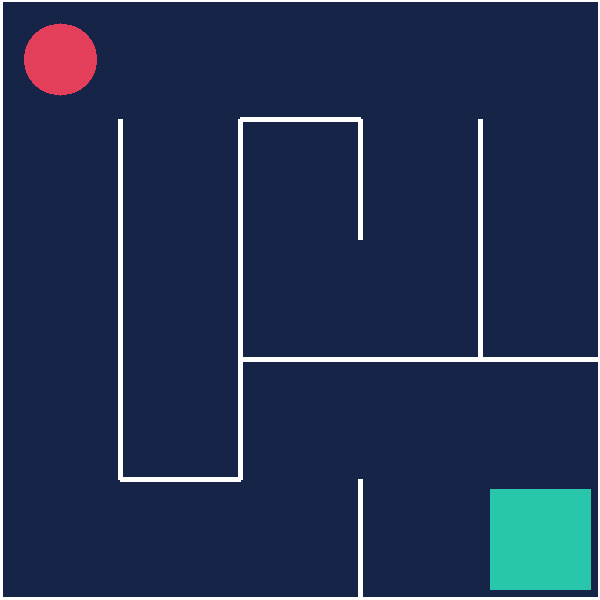

In [16]:
test_agent(env, policy)

![Agent Performance](agent_performance.gif)


# Implement the Policy Iteration algorithm

Policy iteration is a dynamic programming method used to find the optimal policy for a Markov Decision Process (MDP). It consists of two main steps that are iteratively applied:

1. **Policy Evaluation**: Calculate the value function for a given policy, which is an estimation of how good it is to be in a particular state under the current policy.
2. **Policy Improvement**: Improve the policy by making it greedy with respect to the current value function.

## Mathematical Formulation

### 1. **Policy Evaluation**:
For each state $s$, the value function $V(s)$ is updated using the Bellman expectation equation:

\$
V(s) = \sum_a \pi(a|s) \sum_{s'} P(s'|s,a) \left[ R(s, a) + \gamma V(s') \right]
\$

Where:
- $\pi(a|s)$ is the probability of taking action $a$ in state $s$.
- $P(s'|s,a)$ is the transition probability of moving from state $s$ to $s'$ given action $a$.
- $R(s, a)$ is the reward received after taking action $a$ in state $s$.
- $\gamma$ is the discount factor (between 0 and 1).
- $V(s)$ is the state value.

### 2. **Policy Improvement**:
For each state $s$, the policy is improved by selecting the action that maximizes the action-value function $Q(s, a)$:

\$
\pi(s) = \arg\max_a \sum_{s'} P(s'|s,a) \left[ R(s, a) + \gamma V(s') \right]
\$

Where:
- $\pi(s)$ is the updated policy for state $s$.
- $Q(s, a)$ is the expected return of taking action $a$ in state $s$.

### 3. **Policy Iteration**:
The algorithm alternates between policy evaluation and policy improvement until the policy stabilizes.

## Pseudocode

1. **Initialize**: 
   - Policy $\pi$ and state-value function $V$.

2. **Loop until the policy is stable**:
   1. Policy Evaluation: Update the state-value function for the current policy.
   2. Policy Improvement: Update the policy to be greedy with respect to the current value function.

3. **Output**: The optimal policy $\pi^*$ and value function $V^*$.

---

####  Define the policy $\pi(\cdot|s)$


In [17]:
policy_probs = np.full((5, 5, 4), 0.25)
state_values = np.zeros(shape=(5,5))

In [18]:
def policy_evaluation(policy_probs, state_values, theta=1e-6, gamma=0.99):
    delta = float("inf")

    while delta > theta:
        delta = 0

        for row in range(5):
            for col in range(5):
                old_value = state_values[(row, col)]
                new_value = 0
                action_probabilities = policy_probs[(row, col)]

                for action, prob in enumerate(action_probabilities):
                    next_state, reward, _, _ = env.simulate_step((row, col), action)
                    new_value += prob * (reward + gamma * state_values[next_state])

                state_values[(row, col)] = new_value

                delta = max(delta, abs(old_value - new_value))

In [19]:
def policy_improvement(policy_probs, state_values, gamma=0.99):

    policy_stable = True
    for row in range(5):
        for col in range(5):
            old_action = policy_probs[(row, col)].argmax()

            new_action = None
            max_qsa = float("-inf")

            for action in range(4):
                next_state, reward, _, _ = env.simulate_step((row, col), action)
                qsa = reward + gamma * state_values[next_state]
                if qsa > max_qsa:
                    max_qsa = qsa
                    new_action = action

            action_probs = np.zeros(4)
            action_probs[new_action] = 1.
            policy_probs[(row, col)] = action_probs

            if new_action != old_action:
                policy_stable = False

    return policy_stable

In [20]:
def policy_iteration(policy_probs, state_values, theta=1e-6, gamma=0.99):
    policy_stable = False

    while not policy_stable:

        policy_evaluation(policy_probs, state_values, theta, gamma)

        policy_stable = policy_improvement(policy_probs, state_values, gamma)

In [21]:
policy_iteration(policy_probs, state_values)

GIF saved as agent_performance.gif


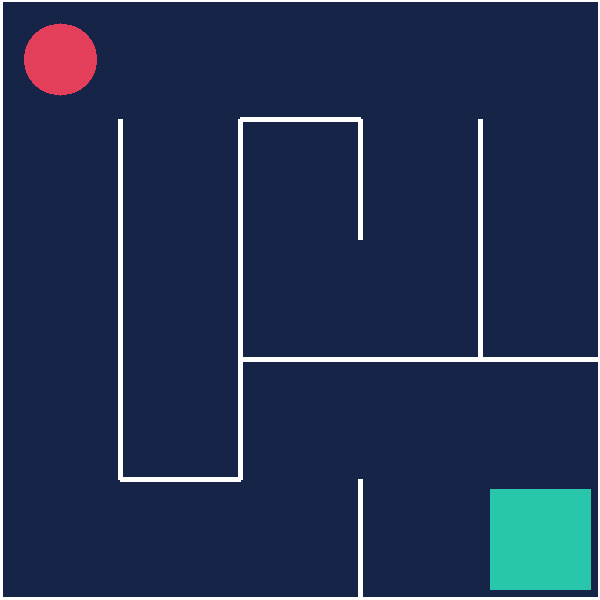

In [22]:
test_agent(env, policy)

![Agent Performance](Policy_Iteration.gif)


# SARSA (State-Action-Reward-State-Action) in Reinforcement Learning

SARSA is an on-policy algorithm for temporal difference (TD) learning. It learns the action-value function, $Q(s, a)$, based on the agent's experience with the environment while following the current policy.

## Mathematical Formulation

### Update Rule:
For each state-action pair $(s, a)$, the action-value function is updated based on the reward received and the estimated value of the next state-action pair $(s', a')$:

\$
Q(s, a) \leftarrow Q(s, a) + \alpha \left[ r + \gamma Q(s', a') - Q(s, a) \right]
\$

Where:
- $Q(s, a)$ is the action-value function for state $s$ and action $a$.
- $\alpha$ is the learning rate (step size).
- $r$ is the reward received after taking action $a$ in state $s$.
- $\gamma$ is the discount factor, which determines the importance of future rewards.
- $(s', a')$ is the next state-action pair.

### Algorithm Steps:
1. **Initialize**:
   - Initialize the action-value function $Q(s, a)$ arbitrarily.
   - Set the learning rate $\alpha$, discount factor $\gamma$, and exploration rate $\epsilon$.

2. **Loop for each episode**:
   - Start from the initial state $s$.
   - Select an action $a$ using an $\epsilon$-greedy policy.
   - Take the action $a$ and observe the reward $r$ and the next state $s'$.
   - Choose the next action $a'$ based on the current policy.
   - Update the action-value function using the SARSA update rule.
   - Repeat until the episode ends.

3. **Output**: The learned action-value function $Q(s, a)$ and the policy derived from it.

## Pseudocode

1. Initialize $Q(s, a)$ arbitrarily.
2. For each episode:
   1. Initialize state $s$.
   2. Choose action $a$ based on policy.
   3. Loop for each step of the episode:
      - Take action $a$, observe reward $r$ and next state $s'$.
      - Choose next action $a'$ based on policy.
      - Update $Q(s, a)$.
      - Set $s = s'$ and $a = a'$.
   4. End when the episode terminates.

In [23]:
action_values = np.zeros(shape=(5, 5, 4))
def policy(state, epsilon=0.):
    if np.random.random() < epsilon:
        return np.random.randint(4)
    else:
        av = action_values[state]
        return np.random.choice(np.flatnonzero(av == av.max()))

In [24]:
def sarsa(action_values, policy, episodes, alpha=0.1, gamma=0.99, epsilon=0.2):

    for episode in range(1, episodes + 1):
        state = env.reset()
        action = policy(state, epsilon)
        done = False
        while not done:
            next_state, reward, done, _ = env.step(action)
            next_action = policy(next_state, epsilon)

            qsa = action_values[state][action]
            next_qsa = action_values[next_state][next_action]
            action_values[state][action] = qsa + alpha * (reward + gamma * next_qsa - qsa)
            state = next_state
            action = next_action

In [25]:
sarsa(action_values, policy, 1000)

GIF saved as agent_performance.gif


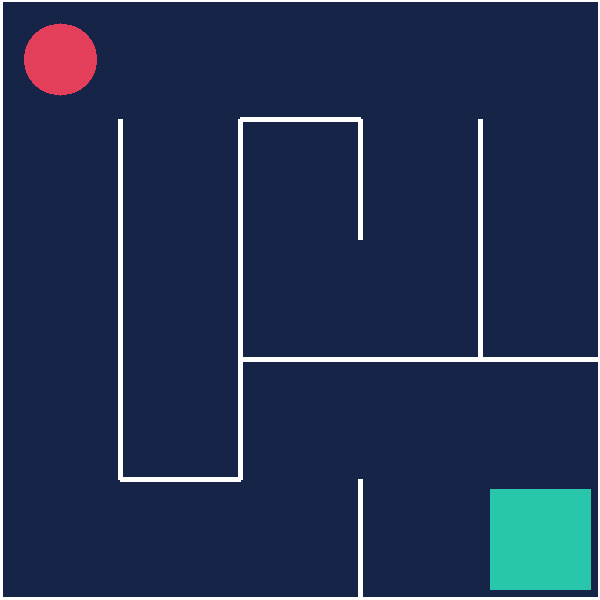

In [26]:
test_agent(env, policy)

![Agent Performance](SARSA.gif)

# Q-learning Algorithm

Q-learning is a model-free, off-policy reinforcement learning algorithm that seeks to learn the value of an action in a particular state. The main idea is to update the action-value function (also known as Q-function) using experiences generated from the interaction between the agent and the environment.

### Q-learning Update Rule

The Q-value is updated using the following formula:

$$
Q(s, a) \leftarrow Q(s, a) + \alpha \left[ r + \gamma \max_{a'} Q(s', a') - Q(s, a) \right]
$$

Where:
- $( s )$ is the current state
- $( a )$ is the current action
- $( r )$ is the reward obtained after performing action \( a \)
- $( s' )$ is the next state
- $( \alpha )$ is the learning rate
- $( \gamma )$ is the discount factor
- $( Q(s, a) )$ is the Q-value for the current state-action pair
- $( \max_{a'} Q(s', a') )$ is the maximum Q-value for the next state over all possible actions

The agent uses an **exploratory policy** during training to balance exploration and exploitation, typically with an epsilon-greedy strategy.

---

### Q-learning Algorithm in Python

Below is an implementation of the Q-learning algorithm:

In [27]:
action_values = np.zeros((5, 5, 4))

def target_policy(state):
    av = action_values[state]
    return np.random.choice(np.flatnonzero(av == av.max()))

def exploratory_policy(state):
    return np.random.randint(4)

In [28]:
def q_learning(action_values, exploratory_policy, target_policy,
               episodes, alpha=0.1, gamma=0.99):

    for episode in range(1, episodes + 1):
        state = env.reset()
        done = False

        while not done:
            action = exploratory_policy(state)
            next_state, reward, done, _ = env.step(action)
            next_action = target_policy(next_state)

            qsa = action_values[state][action]
            next_qsa = action_values[next_state][next_action]
            action_values[state][action] = qsa + alpha * (reward + gamma * next_qsa - qsa)

            state = next_state

In [29]:
q_learning(action_values, exploratory_policy, target_policy, 1000)

GIF saved as agent_performance.gif


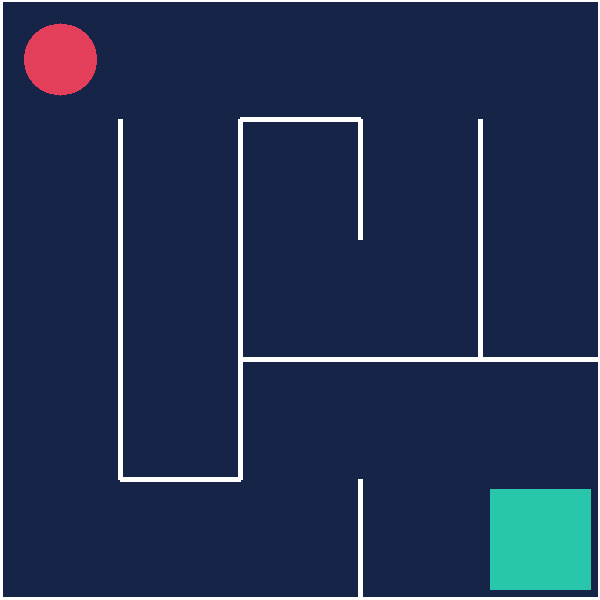

In [30]:
test_agent(env, target_policy)

![Agent Performance](q_learn.gif)
